# HW 7  w2v

In [1]:
import os
import pandas as pd
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.corpus import stopwords

from collections import Counter
from gensim.models import KeyedVectors

import numpy as np
from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Model, Sequential

import matplotlib.pyplot as plt


print(tf.__version__)


#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
ru_emb = KeyedVectors.load_word2vec_format("./cc.ru.300.vec/cc.ru.300.vec")

2.5.0


In [2]:
data =pd.read_excel('отзывы за лето.xls')
data

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [3]:
mystopwords = stopwords.words("russian")
morpher = MorphAnalyzer()


def words_only(text):
    text =str(text)
    return text.lower()   

def remove_punkt(text, ptrn):
    return re.sub(ptrn, ' ', text)

def to_token(text):
    return nltk.tokenize.word_tokenize(text)

def remove_stopwords(text, stop_words = mystopwords):
    return [w for w in text if w not in stop_words]

def join_to_str(text_list):
    return ' '.join(word for word in text_list)

def morphe_text(txt):
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in mystopwords]
    return " ".join(txt)




data['Content_1'] = data['Content'].apply(words_only)
data['Content_1'] = data['Content_1'].apply(remove_punkt, ptrn=r'[^a-zA-Zа-яА-Я0-9]')
data['Content_1'] = data['Content_1'].apply(to_token)
data['Content_1'] = data['Content_1'].apply(remove_stopwords)
data['Content_1'] = data['Content_1'].apply(join_to_str)
data['Content_1'] = data['Content_1'].apply(morphe_text)

data

,Rating,Content,Date,Content_1
0,5,It just works!,2017-08-14,it just works
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,отлично
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать 1 работа антивирус далёкий нику...
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро
...,...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,шляпа роот право бесполезный прога разраб охре...
20655,5,Ок,2017-06-01,около
20656,4,Доволен,2017-06-01,довольный
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,песопаснастя рута нужын


In [4]:
def code_w2v_txt(txt, max_len = 100):
    sent_w2v = []
    zero_point = np.zeros(300)
    txt = txt.split()
   
    for i in range(max_len):
        try:
            word = ru_emb[txt[i]]
        except:
            word = zero_point
        sent_w2v.append(word)
    return np.array(sent_w2v)

max_len = 100
data['w2v'] = data['Content_1'].apply(code_w2v_txt, max_len = max_len)

In [5]:
X=list(data['w2v'].values)
X = np.array(X)
y = data['Rating'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_enc_labels = le.fit_transform(y_train) 
test_enc_labels = le.transform(y_test)
le.classes_

array([1, 2, 3, 4, 5], dtype=int64)

In [8]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Возьмем за бейзлан NN на основе LSTM

In [9]:
num_classes = len(data.Rating.unique())

inputs = L.Input(shape=(X_train.shape[1], X_train.shape[2]))
dropout_embeds = L.SpatialDropout1D(0.05)(inputs)
x = L.Bidirectional(L.LSTM(units=7, return_sequences=True))(dropout_embeds)
pooled_avg_sequences = L.GlobalAveragePooling1D()(x)
pooled_max_sequences = L.GlobalMaxPooling1D()(x)
concated = L.concatenate([pooled_avg_sequences, pooled_max_sequences])
dense_intermediate = L.Dense(64, activation='elu')(concated)
x = L.Dense(num_classes, activation='sigmoid')(dense_intermediate)

model = Model(inputs=inputs, outputs=x)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 14)      17248       spatial_dropout1d[0][0]          
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 14)           0           bidirectional[0][0]              
______________________________________________________________________________________________

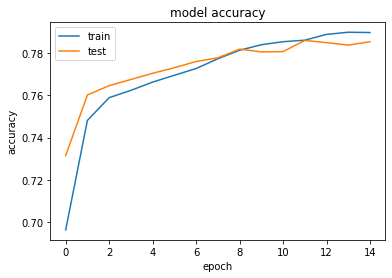

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [11]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 6ms/step - loss: 0.6208 - accuracy: 0.7860


[0.620796263217926, 0.7860076427459717]

# CNN

In [12]:
inputs = L.Input(shape=(X_train.shape[1], X_train.shape[2]))
l_cov1= L.Conv1D(128, 5, activation='relu')(inputs)
l_pool1 = L.MaxPooling1D(2)(l_cov1)
l_cov2 = L.Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = L.MaxPooling1D(2)(l_cov2)
l_cov3 = L.Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = L.MaxPooling1D(5)(l_cov3)  # global max pooling
l_flat = L.Flatten()(l_pool3)
l_dense = L.Dense(128, activation='relu')(l_flat)
preds = L.Dense(64, activation='softmax')(l_dense)
preds = L.Dense(num_classes, activation='softmax')(l_dense)

model = Model(inputs=inputs, outputs=preds)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 300)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 128)            0   

In [13]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

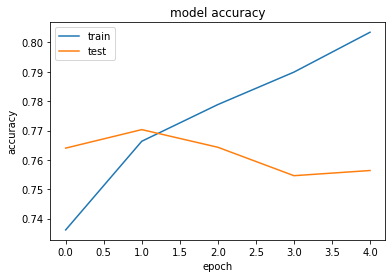

In [14]:
history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [15]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 2s 11ms/step - loss: 0.6435 - accuracy: 0.7703


[0.6435219049453735, 0.7703138589859009]

# Ещё  одна CNN

In [16]:
model = Sequential()
model.add(L.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(L.Conv1D(128, 3))
model.add(L.Activation("relu"))
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(32))
model.add(L.Activation("relu"))
model.add(L.Dense(num_classes))
model.add(L.Activation('softmax'))

In [17]:
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 98, 128)           115328    
_________________________________________________________________
activation (Activation)      (None, 98, 128)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0

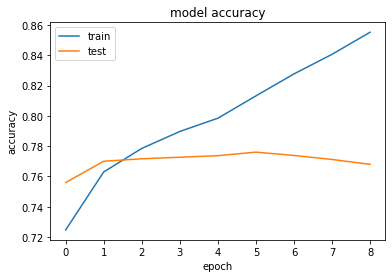

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [19]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 4ms/step - loss: 0.6292 - accuracy: 0.7760


[0.6292178630828857, 0.7760340571403503]

# CNN + LSTM

In [20]:
model = Sequential()
model.add(L.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(L.Conv1D(128, 3))
model.add(L.Bidirectional(L.LSTM(units=32, return_sequences=True)))
model.add(L.Activation("relu"))
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(32))
model.add(L.Activation("relu"))
model.add(L.Dense(num_classes))
model.add(L.Activation('softmax'))

In [21]:
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 98, 128)           115328    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 98, 64)            41216     
_________________________________________________________________
activation_3 (Activation)    (None, 98, 64)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

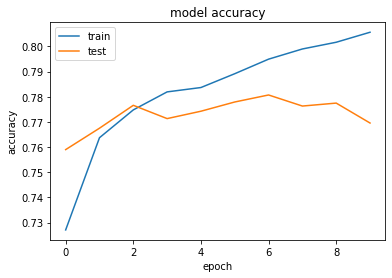

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [23]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 6ms/step - loss: 0.6126 - accuracy: 0.7807


[0.6125920414924622, 0.7807275056838989]

# И ещё  одна CNN

In [24]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
def make_model(X_train):
    inputs = L.Input(shape=(X_train.shape[1], X_train.shape[2]))

    
    conv1 = L.Conv1D(filters=64, kernel_size=3, padding="same")(inputs)
    conv1 = L.BatchNormalization()(conv1)
    conv1 = L.ReLU()(conv1)

    conv2 = L.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = L.BatchNormalization()(conv2)
    conv2 = L.ReLU()(conv2)

    conv3 = L.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = L.BatchNormalization()(conv3)
    conv3 = L.ReLU()(conv3)

    gap = L.GlobalAveragePooling1D()(conv3)

    output_layer = L.Dense(num_classes, activation="softmax")(gap)

    model = Model(inputs=inputs, outputs=output_layer)
    model.summary()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])
    return model 


model = make_model(X_train)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 300)]        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           57664     
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (None, 100, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 100, 64)           0   

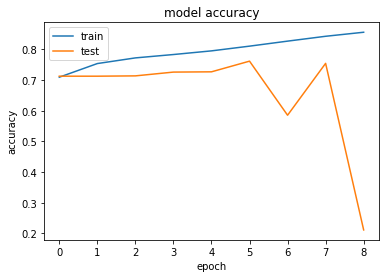

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [26]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.7615


[0.6791784763336182, 0.7615136504173279]

# И ещё  одна CNN

In [27]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = L.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = L.Conv1D(filters, 3, padding="same")(x)
        x = L.Activation(activation)(x)
    x = L.Conv1D(filters, 3, padding="same")(x)
    x = L.Add()([x, s])
    x = L.Activation(activation)(x)
    return L.MaxPool1D(pool_size=2, strides=2)(x)



def build_model(X_train, num_classes):
    inputs = L.Input(shape=(X_train.shape[1], X_train.shape[2]))

    
    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = L.AveragePooling1D(pool_size=3, strides=3)(x)
    x = L.Flatten()(x)
    x = L.Dense(256, activation="relu")(x)
    x = L.Dense(128, activation="relu")(x)

    outputs = L.Dense(num_classes, activation="softmax", name="output")(x)

    
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])
    return model 


In [28]:
model = build_model(X_train, num_classes)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 100, 16)      14416       input_6[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 100, 16)      0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 100, 16)      784         activation_6[0][0]               
____________________________________________________________________________________________

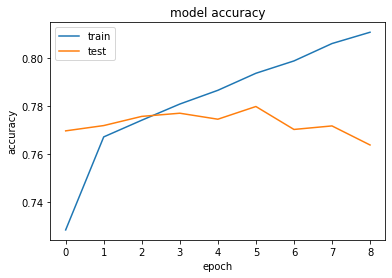

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [30]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 3s 12ms/step - loss: 0.6786 - accuracy: 0.7797


[0.6785920262336731, 0.7797008156776428]

# Transformer 

In [31]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [32]:
dim = 300
embed_dim = dim  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 100  # Hidden layer size in feed forward network inside transformer

inputs = L.Input(shape=(X_train.shape[1], X_train.shape[2]))

transformer_block = TransformerBlock(dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)


model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 300)]        0         
_________________________________________________________________
transformer_block (Transform (None, 100, 300)          783700    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                6020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 105 

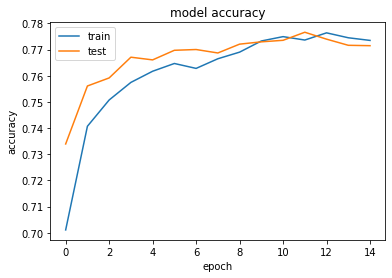

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(X_train, train_enc_labels, batch_size=128, epochs=25, 
          validation_data=(X_test, test_enc_labels), callbacks=[callback], verbose=0)
plot_history(history)

In [34]:
model.evaluate(X_test, test_enc_labels)

214/214 [==============================] - 2s 8ms/step - loss: 0.6472 - accuracy: 0.7766


[0.6471986174583435, 0.7766206860542297]

# Выводы.

### Лучше всего себя показали не глубокие (простенькие) CNN и LSTM сети. Трансформер немного уступил.

### Подход с использованием слоя EMBEDDING показал себя несколько лучше чем W2V.